In [ ]:
! pip install torch transformers diffusers==0.3.0 numpy pillow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import torch
from transformers import CLIPModel, CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel

In [ ]:
#Init CLIP tokenizer and model
model_path_clip = "openai/clip-vit-large-patch14"
clip_tokenizer = CLIPTokenizer.from_pretrained(model_path_clip)
clip_model = CLIPModel.from_pretrained(model_path_clip, torch_dtype=torch.float16)
clip = clip_model.text_model

#Init diffusion model
model_path_diffusion = "CompVis/stable-diffusion-v1-4"
unet = UNet2DConditionModel.from_pretrained(model_path_diffusion, subfolder="unet", use_auth_token=auth_token, revision="fp16", torch_dtype=torch.float16)
vae = AutoencoderKL.from_pretrained(model_path_diffusion, subfolder="vae", use_auth_token=auth_token, revision="fp16", torch_dtype=torch.float16)

#Move to GPU
device = "cuda"
unet.to(device)
vae.to(device)
clip.to(device)
print("Loaded all models")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loaded all models


In [ ]:

import numpy as np
import random
from PIL import Image
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from difflib import SequenceMatcher
from IPython.display import display
import requests
from io import BytesIO

def init_attention_weights(weight_tuples):
    tokens_length = clip_tokenizer.model_max_length
    weights = torch.ones(tokens_length)

    for i, w in weight_tuples:
        if i < tokens_length and i >= 0:
            weights[i] = w


    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.last_attn_slice_weights = weights.to(device)
        if module_name == "CrossAttention" and "attn1" in name:
            module.last_attn_slice_weights = None


def init_attention_edit(tokens, tokens_edit):
    tokens_length = clip_tokenizer.model_max_length
    mask = torch.zeros(tokens_length)
    indices_target = torch.arange(tokens_length, dtype=torch.long)
    indices = torch.zeros(tokens_length, dtype=torch.long)

    tokens = tokens.input_ids.numpy()[0]
    tokens_edit = tokens_edit.input_ids.numpy()[0]

    for name, a0, a1, b0, b1 in SequenceMatcher(None, tokens, tokens_edit).get_opcodes():
        if b0 < tokens_length:
            if name == "equal" or (name == "replace" and a1-a0 == b1-b0):
                mask[b0:b1] = 1
                indices[b0:b1] = indices_target[a0:a1]

    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.last_attn_slice_mask = mask.to(device)
            module.last_attn_slice_indices = indices.to(device)
        if module_name == "CrossAttention" and "attn1" in name:
            module.last_attn_slice_mask = None
            module.last_attn_slice_indices = None


def init_attention_func():
    def new_attention(self, query, key, value, sequence_length, dim):
        batch_size_attention = query.shape[0]
        hidden_states = torch.zeros(
            (batch_size_attention, sequence_length, dim // self.heads), device=query.device, dtype=query.dtype
        )
        slice_size = self._slice_size if self._slice_size is not None else hidden_states.shape[0]
        for i in range(hidden_states.shape[0] // slice_size):
            start_idx = i * slice_size
            end_idx = (i + 1) * slice_size
            attn_slice = (
                torch.einsum("b i d, b j d -> b i j", query[start_idx:end_idx], key[start_idx:end_idx]) * self.scale
            )
            attn_slice = attn_slice.softmax(dim=-1)

            if self.use_last_attn_slice:
                if self.last_attn_slice_mask is not None:
                    new_attn_slice = torch.index_select(self.last_attn_slice, -1, self.last_attn_slice_indices)
                    attn_slice = attn_slice * (1 - self.last_attn_slice_mask) + new_attn_slice * self.last_attn_slice_mask
                else:
                    attn_slice = self.last_attn_slice

                self.use_last_attn_slice = False

            if self.save_last_attn_slice:
                self.last_attn_slice = attn_slice
                self.save_last_attn_slice = False

            if self.use_last_attn_weights and self.last_attn_slice_weights is not None:
                attn_slice = attn_slice * self.last_attn_slice_weights
                self.use_last_attn_weights = False

            attn_slice = torch.einsum("b i j, b j d -> b i d", attn_slice, value[start_idx:end_idx])

            hidden_states[start_idx:end_idx] = attn_slice

        # reshape hidden_states
        hidden_states = self.reshape_batch_dim_to_heads(hidden_states)
        return hidden_states

    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention":
            module.last_attn_slice = None
            module.use_last_attn_slice = False
            module.use_last_attn_weights = False
            module.save_last_attn_slice = False
            module._attention = new_attention.__get__(module, type(module))

def use_last_tokens_attention(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.use_last_attn_slice = use

def use_last_tokens_attention_weights(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.use_last_attn_weights = use

def use_last_self_attention(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn1" in name:
            module.use_last_attn_slice = use

def save_last_tokens_attention(save=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.save_last_attn_slice = save

def save_last_self_attention(save=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn1" in name:
            module.save_last_attn_slice = save

@torch.no_grad()
def stablediffusion(prompt="", prompt_edit=None, prompt_edit_token_weights=[], prompt_edit_tokens_start=0.0, prompt_edit_tokens_end=1.0,
                    prompt_edit_spatial_start=0.0, prompt_edit_spatial_end=1.0, guidance_scale=9.5, steps=50, seed=43, width=512, height=512,
                    init_image=None, init_image_strength=0.5, init_latent=None):
    width = width - width % 64
    height = height - height % 64

    if seed is None:
        seed = random.randrange(2**32 - 1)
    generator = torch.cuda.manual_seed(seed)

    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    scheduler.set_timesteps(steps)

    # ----- Init latent -----
    if init_latent is not None:
        latent = init_latent.to(device)
        t_start = steps - int(steps * init_image_strength)

    elif init_image is not None:
        init_image = init_image.resize((width, height), resample=Image.LANCZOS)
        init_image = np.array(init_image).astype(np.float32) / 255.0 * 2.0 - 1.0
        init_image = torch.from_numpy(init_image[np.newaxis, ...].transpose(0, 3, 1, 2))

        if init_image.shape[1] > 3:
            init_image = init_image[:, :3] * init_image[:, 3:] + (1 - init_image[:, 3:])
        init_image = init_image.to(device)

        with autocast(device):
            init_latent = vae.encode(init_image).latent_dist.sample(generator=generator) * 0.18215

        t_start = steps - int(steps * init_image_strength)

    else:
        init_latent = torch.zeros((1, unet.in_channels, height // 8, width // 8), device=device)
        t_start = 0

    noise = torch.randn(init_latent.shape, generator=generator, device=device)
    latent = scheduler.add_noise(init_latent, noise, t_start).to(device)

    #Tokenizing prompts
    with autocast(device):
        tokens_uncond = clip_tokenizer(
            "", padding="max_length", max_length=clip_tokenizer.model_max_length,
            truncation=True, return_tensors="pt"
        )
        embedding_uncond = clip(tokens_uncond.input_ids.to(device)).last_hidden_state

        tokens_prompt = clip_tokenizer(
            prompt, padding="max_length", max_length=clip_tokenizer.model_max_length,
            truncation=True, return_tensors="pt"
        )
        embedding_prompt = clip(tokens_prompt.input_ids.to(device)).last_hidden_state

        if prompt_edit is not None:
            tokens_edit = clip_tokenizer(
                prompt_edit, padding="max_length", max_length=clip_tokenizer.model_max_length,
                truncation=True, return_tensors="pt"
            )
            embedding_edit = clip(tokens_edit.input_ids.to(device)).last_hidden_state

            init_attention_edit(tokens_prompt, tokens_edit)

    #Init of the attention patch
    init_attention_func()
    init_attention_weights(prompt_edit_token_weights)

    timesteps = scheduler.timesteps[t_start:]

    for i, t in tqdm(enumerate(timesteps), total=len(timesteps)):
        t_index = t_start + i
        sigma = scheduler.sigmas[t_index]

        latent_input = latent / ((sigma**2 + 1) ** 0.5)
        latent_input = latent_input.to(unet.dtype)

        noise_pred_uncond = unet(latent_input, t, encoder_hidden_states=embedding_uncond).sample

        if prompt_edit is not None:
            save_last_tokens_attention()
            save_last_self_attention()
        else:
            use_last_tokens_attention_weights()

        noise_pred_cond = unet(latent_input, t, encoder_hidden_states=embedding_prompt).sample

        if prompt_edit is not None:
            t_scale = t / scheduler.num_train_timesteps
            if prompt_edit_tokens_start <= t_scale <= prompt_edit_tokens_end:
                use_last_tokens_attention()
            if prompt_edit_spatial_start <= t_scale <= prompt_edit_spatial_end:
                use_last_self_attention()

            use_last_tokens_attention_weights()
            noise_pred_cond = unet(latent_input, t, encoder_hidden_states=embedding_edit).sample

        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
        latent = scheduler.step(noise_pred, t_index, latent).prev_sample

    # Decode
    latent = latent / 0.18215
    image = vae.decode(latent.to(vae.dtype)).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image[0] * 255).round().astype("uint8")
    return Image.fromarray(image)


def prompt_token(prompt, index):
    tokens = clip_tokenizer(prompt, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True).input_ids[0]
    return clip_tokenizer.decode(tokens[index:index+1])

def show_token_indices(prompt):
    tokens = clip_tokenizer(prompt, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True).input_ids[0]
    for index in range(len(tokens)):
        decoded_token = clip_tokenizer.decode(tokens[index:index+1])
        print(f'{index}:', decoded_token)
        if decoded_token == "<|endoftext|>":
            break

In [ ]:

image_edited = stablediffusion(
    prompt="a white cat on a chair",
    prompt_edit="a black cat on a chair",
    prompt_edit_token_weights=[(10, 1.5)],
    prompt_edit_tokens_start=0.2,
    prompt_edit_tokens_end=0.8,
    prompt_edit_spatial_start=0.3,
    prompt_edit_spatial_end=1.0,
    init_latent=latent_from_null_text_inversion,
    init_image_strength=0.6,
    guidance_scale=8.5,
    steps=50,
    seed=12345,
    width=512,
    height=512
)

In [ ]:
prompt = "A fluffy ball in a garden"
seed = 43

In [ ]:

show_token_indices(prompt)

0: <|startoftext|>
1: a
2: fluffy
3: ball
4: in
5: a
6: garden
7: <|endoftext|>


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

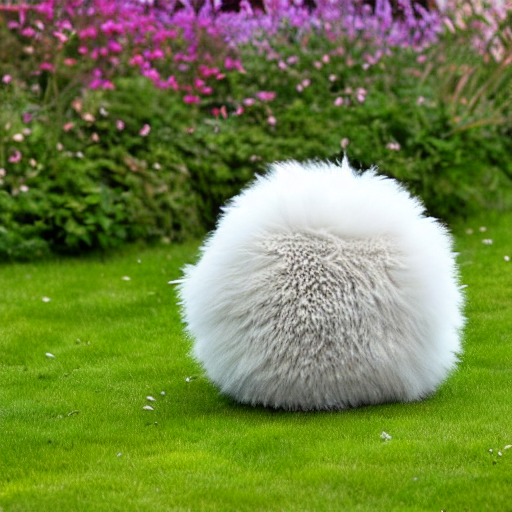

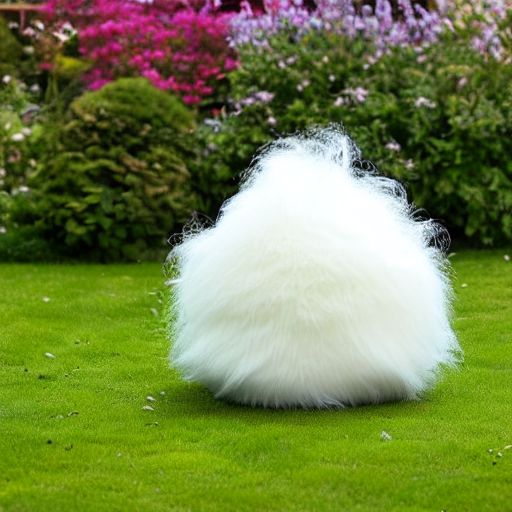

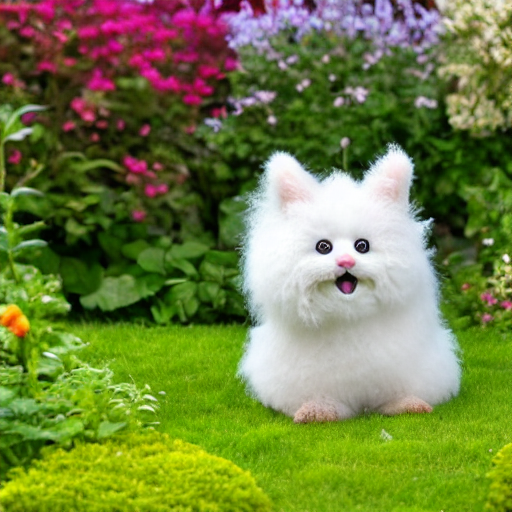

In [ ]:
base = stablediffusion(prompt, seed=seed)
morefluffy = stablediffusion(prompt, prompt_edit_token_weights=[(2, 6)], seed=seed) # donne plus d'importance au mot fluffy
lessfluffy = stablediffusion(prompt, prompt_edit_token_weights=[(3, -1)], seed=seed) # donne moins d importance au mot ball ?

imgs = [base, morefluffy, lessfluffy]
display(*imgs)

In [ ]:
winter = stablediffusion(prompt, prompt + " in winter", seed=seed)
imgs = [base, winter]
display(*imgs)

winter_snow = stablediffusion(prompt, prompt + " in winter during a snow storm", seed=seed)
imgs2 = [ winter_snow]
display(*imgs2)

NameError: name 'unet' is not defined

In [ ]:
promptcat="a cat in a garden"

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

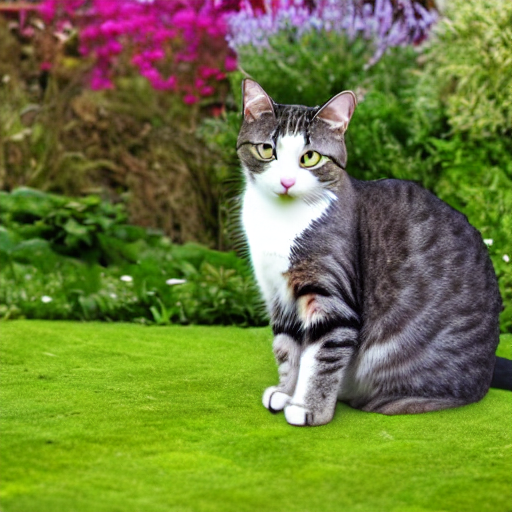

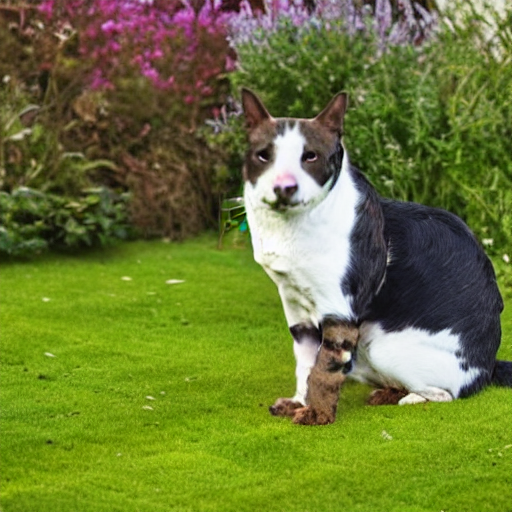

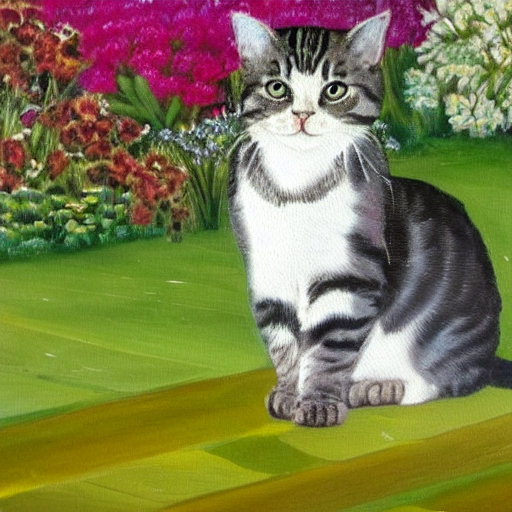

In [ ]:
cat = stablediffusion(promptcat, seed=seed)
motorcycle = stablediffusion(promptcat, promptcat.replace("cat", "dog"),  seed=seed)
prompt_edit_token_weights=[(1, 20)] # <- permet de donner plus ou moins d'importance a la modif
painting = stablediffusion(promptcat, "a painting of " + promptcat, seed=seed)



display(*[cat,motorcycle,painting])

test DDIM Inversion

In [ ]:
prompt_img="A photo of a cute orange cat with green eyes"

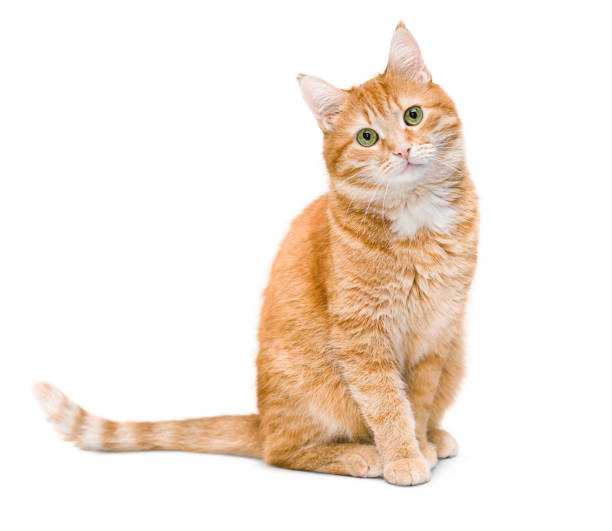

In [ ]:

init_image = Image.open("/content/orange_cat.jpg")
init_image


In [ ]:
gray_cat=stablediffusion(prompt_img,prompt_img.replace("orange","gray"),seed=seed,init_image=init_image,init_image_strength=0.65)
#gray_cat=stablediffusion(prompt_img,seed=seed,init_image=init_image,guidance_scale=8,init_image_strength=0.29)
#gray_cat=stablediffusion(prompt_img,seed=seed,init_image=init_image,guidance_scale=1,init_image_strength=0.15) #sans classifier free guidance

gray_cat


  0%|          | 0/32 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 476.12 MiB is free. Process 8971 has 14.27 GiB memory in use. Of the allocated memory 14.07 GiB is allocated by PyTorch, and 74.09 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
prompt_img2="A photo of a black cat on a blue skateboard "

In [ ]:
init_image2 = Image.open("/content/cat_skateboard.jpg")
init_image2

FileNotFoundError: [Errno 2] No such file or directory: '/content/cat_skateboard.jpg'

In [ ]:
bicycle_cat=stablediffusion(prompt_img2,prompt_img2.replace("skateboard","table"),seed=seed,init_image=init_image2,init_image_strength=0.65)

bicycle_cat

Null-Text Inversion